<a href="https://colab.research.google.com/github/ksee1230/NL_team12/blob/master/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC_NSMC_12%EC%A1%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

konlpy 설치 및 필요 모듈 import

In [51]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 2s (159 kB/s)
Reading package lists... Done
Reading package lists... Done
Building de

In [52]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

데이터 로드

In [53]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/ksee1230/NL_team12/master/ko_data.csv", filename="ratings_test.csv")

train_data = pd.read_table('ratings.txt')
test_data = pd.read_csv('ratings_test.csv', encoding = 'utf-8')

데이터 로드 후 data 확인

In [54]:
print('훈련용 리뷰 개수:',len(train_data))
train_data[:5]

훈련용 리뷰 개수: 200000


,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [55]:
print('테스트용 리뷰 개수:', len(test_data))
test_data[:5]

테스트용 리뷰 개수: 11187


,Id,Sentence
0,0,정말 많이 울었던 영화입니다.
1,1,시간 낭비예요.
2,2,포스터를 저렇게밖에 만들지 못했던 제작자의 소심함에 침을 뱉고 싶다.
3,3,지금 봐도 재미있는 영화!!! 코믹과 감동!!! 그리고 요리!!!
4,4,이걸 영화로 만드는 거야?얼마나 가는지 보자.


# 데이터 정제

(1) 중복 데이터 제거

In [56]:
train_data['document'].nunique()
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 194544


In [57]:
print(train_data.isnull().values.any())

True


In [58]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


(2) 정규 표현식을 통해 한글과 공백을 제외한 모든 데이터 제거

In [59]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [60]:
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    491
label         0
dtype: int64


In [61]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

194052


In [62]:
test_data['Sentence'] = test_data['Sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 11187


(3) 불용어 제거 및 토큰화


In [63]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()

In [64]:
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [65]:
X_test = []
for sentence in test_data['Sentence']:
   temp_X = []
   temp_X = okt.morphs(sentence, stem=True) # 토큰화
   temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
   X_test.append(temp_X)

(4) 정수 인코딩

In [66]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [67]:
total_cnt = len(tokenizer.word_index)
vocab_size = total_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 49646


In [68]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [69]:
y_train = np.array(train_data['label'])

(5) 패딩

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.996325727124688


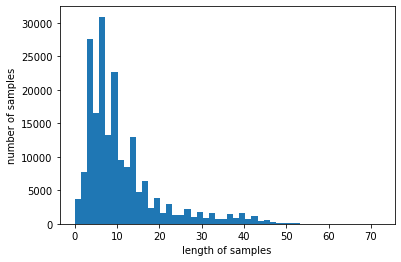

In [70]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [71]:
max_len = 70

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# 모델 설계 및 학습

In [72]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [73]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [74]:
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
ckpt = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [75]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[earlystop, ckpt], batch_size=60, validation_split=0.2)

Epoch 1/15
2588/2588 [==============================] - ETA: 0s - loss: 0.3703 - acc: 0.8324
Epoch 00001: val_acc improved from -inf to 0.78648, saving model to best_model.h5
2588/2588 [==============================] - 436s 168ms/step - loss: 0.3703 - acc: 0.8324 - val_loss: 0.4431 - val_acc: 0.7865
Epoch 2/15
2588/2588 [==============================] - ETA: 0s - loss: 0.3111 - acc: 0.8657
Epoch 00002: val_acc improved from 0.78648 to 0.81740, saving model to best_model.h5
2588/2588 [==============================] - 449s 174ms/step - loss: 0.3111 - acc: 0.8657 - val_loss: 0.4330 - val_acc: 0.8174
Epoch 3/15
2588/2588 [==============================] - ETA: 0s - loss: 0.2864 - acc: 0.8796
Epoch 00003: val_acc improved from 0.81740 to 0.82879, saving model to best_model.h5
2588/2588 [==============================] - 452s 175ms/step - loss: 0.2864 - acc: 0.8796 - val_loss: 0.3964 - val_acc: 0.8288
Epoch 4/15
2588/2588 [==============================] - ETA: 0s - loss: 0.2638 - acc: 0.

모델을 통해 test 데이터에 대한 결과 예측 및 csv 변환

In [76]:
loaded_model = load_model('best_model.h5')
prediction = loaded_model.predict_classes(X_test, verbose=0)

prediction = prediction.flatten().tolist()

id = list(range(len(prediction)))

dic = {'Id': id,
       'Predicted': prediction}

df = pd.DataFrame(dic)
df.to_csv('sample.csv', sep=',', index = False)